# Analyzing historical data for all vessels in a specific vessel class

## Setup
Install the Signal Ocean SDK:
```
pip install signal-ocean
```
Set your subscription key, acquired here: [https://apis.signalocean.com/profile](https://apis.signalocean.com/profile)

In [1]:
signal_ocean_api_key = '' #replace with your subscription key

## Example 1: Number of spot and relet vessels over time
In this example, a supply trend is generated in order to calculate the number of spot and relet vessels which open in specific areas. A time period of 5 days is explored here but this number can go up until the date you subscribed to The Signal Ocean Platform.

First, get a historical tonnage list containing the relevant data:

In [2]:
from datetime import date, timedelta
from signal_ocean import Connection
from signal_ocean.tonnage_list import (
    TonnageListAPI,
    VesselClassFilter,
    PortFilter,
    VesselFilter,
    MarketDeployment,
    VesselSubclass,
    DateRange
)

connection = Connection(signal_ocean_api_key)
api = TonnageListAPI(connection)

vessel_class_filter = VesselClassFilter(name_like="aframax")
vessel_class = api.get_vessel_classes(vessel_class_filter)[0]

port_filter = PortFilter(name_like="ceyhan")
port = api.get_ports(port_filter)[0]

laycan_end_in_days = 512
start_date = date.today() - timedelta(days=5)
end_date = date.today()

vessel_filter = VesselFilter(
    market_deployments=[MarketDeployment.RELET, MarketDeployment.SPOT],
    vessel_subclass=VesselSubclass.DIRTY,
    latest_ais_since=5,
)

historical_tonnage_list = api.get_historical_tonnage_list(
    port,
    vessel_class,
    laycan_end_in_days,
    DateRange(start_date, end_date),
    vessel_filter=vessel_filter,
)


Then, convert the data to a data frame, filter, and plot:

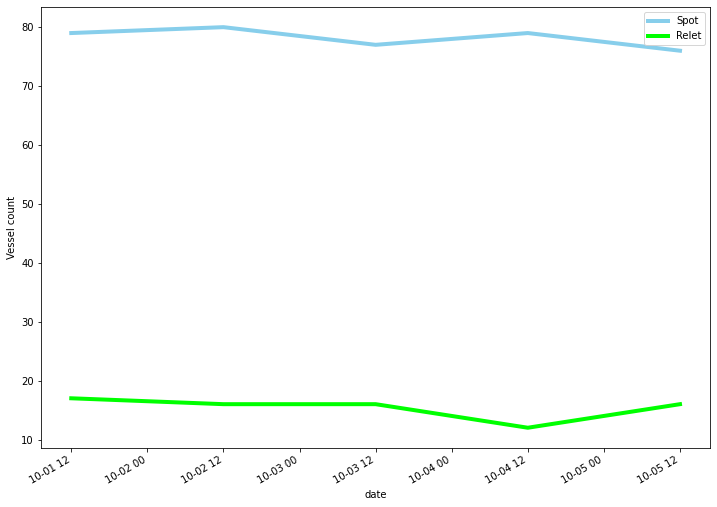

In [3]:
from signal_ocean.tonnage_list import IndexLevel

data_frame = historical_tonnage_list.to_data_frame()
open_areas_of_interest = [
    "Iberian Atlantic Coast",
    "British Isles",
    "North Sea",
    "Baltic Sea Low",
    "Baltic Sea Upper",
    "Continent",
]
areas_filter = data_frame.open_narrow_area_point_in_time.isin(
    open_areas_of_interest
)

spot_filter = data_frame.market_deployment_point_in_time == "Spot"
spot_vessels = (
    data_frame[spot_filter & areas_filter]
    .groupby(IndexLevel.DATE, sort=True)
    .size()
)

relet_filter = data_frame.market_deployment_point_in_time == "Relet"
relet_vessels = (
    data_frame[relet_filter & areas_filter]
    .groupby(IndexLevel.DATE, sort=True)
    .size()
)

ax = spot_vessels.plot(
    markerfacecolor="blue",
    color="skyblue",
    linewidth=4,
    label="Spot",
    figsize=(12, 9),
)
ax2 = relet_vessels.plot(
    ax=ax,
    markerfacecolor="darkgreen",
    color="lime",
    linewidth=4,
    label="Relet",
    figsize=(12, 9),
)

ax2.set_ylabel("Vessel count")
ax2.legend()


## Example 2: Number of ballast unfixed vessels in the Mediterranean and Black Sea 

In this example, the same data collected from the first call will be used to detect ballast unfixed vessels in the Mediterranean and Black Sea areas.

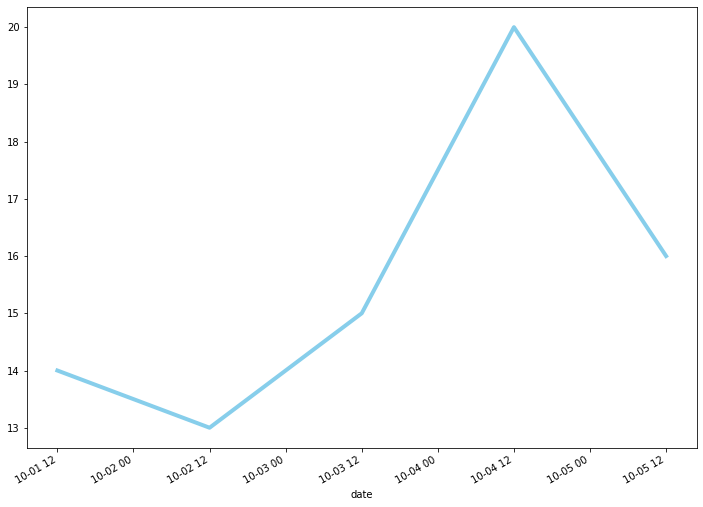

In [4]:
from signal_ocean.tonnage_list import OperationalStatus

data_frame = historical_tonnage_list.to_data_frame()
open_areas_of_interest = [
    "East Mediterranean",
    "Central Mediterranean",
    "West Mediterranean",
    "Black Sea",
]

operationalStatuses = [OperationalStatus.BALLAST_UNFIXED]
areas_filter = data_frame.open_narrow_area_point_in_time.isin(
    open_areas_of_interest
)
operational_status_filter = data_frame.operational_status_point_in_time.isin(
    operationalStatuses
)

aggregatedData = (
    data_frame[operational_status_filter & areas_filter]
    .groupby(IndexLevel.DATE, sort=True)
    .size()
)


ax = aggregatedData.plot(
    markerfacecolor="blue",
    color="skyblue",
    linewidth=4,
    label="Spot",
    figsize=(12, 9),
)

ax2.set_ylabel("Vessel count")
ax2.legend()
